In [1]:
import os
import torch
import torch.optim as optim
from multi_task_model import Multi_task_model
from multi_task_loss import Multi_task_loss_fn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from rpn_utils import *
from utils import (
    save_model,
    save_optimizer,
    load_model,
    check_accuracies,
    save_some_examples,
    transforms
)
from kitti_3d_multi_warmup import *
from easydict import EasyDict as edict
from torch.utils.data import Dataset, DataLoader
from multi_task_dataset import multi_task_dataset

In [2]:
# Hyperparameters

"""
mention the tasks.
TASKS : list [["task name", no. of classes],["task name", no. of classes]....]
task names : "semantic_segmentation", "lane_marking", "drivable_area", "object_detection"

BACKBONE : one of resnet18, resnet34, resnet50, resnet101, resnet150. 

"""
#file_dir= os.path.dirname(__file__) 

rpn_conf = Config()
precomputed = True
cache_folder = 'pickle'

if precomputed == True:
    rpn_conf.anchors = pickle_read(os.path.join(cache_folder, 'anchors.pkl'))
    rpn_conf.bbox_means = pickle_read(os.path.join(cache_folder, 'bbox_means.pkl'))
    rpn_conf.bbox_stds = pickle_read(os.path.join(cache_folder, 'bbox_stds.pkl'))
#print('conf',rpn_conf)

LEARNING_RATE = 0.00001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:',DEVICE)
BATCH_SIZE = 1
TASKS = [["semantic_segmentation", 22], ["object_detection", 10],["mono_3D_object_detection",10]]
tasks_name = "three_task"
BACKBONE = "resnet34"  # one of resnet18, resnet34, resnet50, resnet101, resnet150.
IMAGE_WIDTH = 960
IMAGE_HEIGHT = 608
WEIGHT_DECAY = 0.0005
EPOCHS = 200
NUM_WORKERS =8
PIN_MEMORY = True
LOAD_MODEL = False
WRITER = True  # Controlling the tensorboard
CONF_THRESHOLD = 0.5  # confidence of yolo model for the prediction
IOU_THRESH = 0.5
NMS_THRESH = 0.5
LOAD_MODEL_FILE = "models/" + tasks_name + "/" + tasks_name + "_172_.pth"
# LOAD_MODEL_FILE = "models/" + tasks_name + "/" + tasks_name + "5" + "_.pth"
SAVE_MODEL_FILE = "models/" + tasks_name + "/"  # folder to save models
SAVE_PATH = "predictions/" + tasks_name + "/"  # folder to save predictions
if not os.path.exists(SAVE_MODEL_FILE):
    os.makedirs(SAVE_MODEL_FILE)
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
DATASET_DIR = "A2D2_dataset" # labels main directory
IMG_DIR = "images"  # complete images
TRAIN_CSV= os.path.join(DATASET_DIR , "train.csv")
TEST_CSV=  os.path.join(DATASET_DIR , "subset3.csv")
MONO_3D_LABEL_DIR= "A2D2_3D_Obj_det_label_txt"
SEMANTIC_LABEL_DIR= "seg_label"
DET_2D_LABEL_DIR= 'YOLO_Bbox_2D_label'

S = [IMAGE_HEIGHT // 32, IMAGE_HEIGHT // 16, IMAGE_HEIGHT // 8]
ANCHORS = [[[0.28, 0.22], [0.38, 0.48], [0.9, 0.78]],
           [[0.07, 0.15], [0.15, 0.11], [0.14, 0.29]],
           [[0.02, 0.03], [0.04, 0.07], [0.08, 0.06]]]
scaled_anchors = (torch.tensor(ANCHORS) * (torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))).to(DEVICE)
train_transform, test_transform = transforms(IMAGE_WIDTH=IMAGE_WIDTH, IMAGE_HEIGHT=IMAGE_HEIGHT)


Using device: cuda


In [3]:
def visualize_result(preds, batch_idx):
    transform= T.ToPILImage()
    preds = torch.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)
    preds= (preds.float())*12
    img= transform(preds).convert('RGB')
    image_name= r'./predictions/three_task/Semantic_Segmetation/saved_images_new/Image_{}.png'.format(batch_idx)
    #print('result_saved')
    img.save(image_name)
    
def visualize_target(targets, batch_idx):
    transform= T.ToPILImage()
    targets= (targets.float())*12
    img= transform(targets).convert('RGB')
    image_name= r'./predictions/three_task/Semantic_Segmetation/saved_targets_new/Image_{}.png'.format(batch_idx)
    img.save(image_name)

In [4]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()
def plot_couple_examples(model, loader, thresh, iou_thresh, anchors):
    model.eval()
    for batch_idx, imobj in enumerate(loader):
    #x, y = next(iter(loader))
        x= imobj["image"]
        y= imobj["yolo_target"]
        x = x.to("cuda:0")
    
        #Plotting gt
        boxes = []
        #print('x', x[0].shape)
        for i in range(y[0].shape[1]):
            anchor = anchors[i]
            #print(anchor.shape)
            #print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
            boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
            #print('boxes_after_nms', len(boxes))
            #plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)
            print('gt')
            path= r"./predictions/three_task/Object_detection/gt_{}.png".format(batch_idx)
            plot_image(x[0].permute(1,2,0).detach().to("cpu"), boxes, path)
            #print(x[0].shape
        with torch.no_grad():
            output, features = model(x.float())
            out= output["object_detection"]
            bboxes = [[] for _ in range(x.shape[0])]
            for i in range(3):
                batch_size, A, S, _, _ = out[i].shape
                anchor = anchors[i]
                boxes_scale_i = cells_to_bboxes(
                    out[i], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes[idx] += box

            model.train()

        for i in range(batch_size):
            nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
            )
            print('pred')
            path= r"./predictions/three_task/Object_detection/pred_{}.png".format(batch_idx)
            plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes, path)

def plot_image(image, boxes, path):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = A2D2_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    #plt.show()
    fig.savefig(path)
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Video explanation of this function:
    https://youtu.be/YDkjWEN8jNA

    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

A2D2_CLASSES = [
    "Car",
    "Pedestrian",
    "Truck",
    "VanSUV",
    "Cyclist",
    "Bus",
    "MotorBiker",
    "Bicycle",
    "UtilityVehicle",
    "Motorcycle"
]

In [5]:


def eval_fn(test_loader, model, tasks, dataset):
    for task in tasks:
        if task[0]== "semantic_segmentation":
            loop = tqdm(test_loader, leave=True)
            for batch_idx, imobj in enumerate(loop):
                x= imobj["image"]
                x= x.to(DEVICE)
                with torch.no_grad():
                    out, features = model(x.float())

                visualize_result(out[task[0]], batch_idx)
                visualize_target(imobj["semantic_label"], batch_idx)
            #pass
        elif task[0] == "object_detection":
            #    plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
            pass
        elif task[0] == "mono_3D_object_detection":
                start_iter= 0
                iterator = None
                device= 'cuda'
                result_path= r'./predictions/three_task/Mono_3d_Object_Detection/result_new'
                for iteration in range(start_iter, len(dataset)):
                    print("{}/{}".format(iteration,len(dataset)))
                    iterator, imobjs = next_iteration(test_loader, iterator)
                    image, gts= imobjs["image"], imobjs["mono_3D_gts"]
                    image= image.to(device)
                    post_nms_det  = im_detect_3d(image, model, rpn_conf, imobjs["P"])
                    name= '{}'.format(iteration)
                    file = open(os.path.join(result_path, name + '.txt'), 'w')
                    text_to_write = '' 
                    for boxind in range(post_nms_det.shape[0]):
                        box = post_nms_det[boxind, :]
                        score = box[4]
                        #print(score)
                        cls = rpn_conf.lbls[int(box[5] - 1)]
                        if score >= 0.85:
                            x1 = box[0]
                            y1 = box[1]
                            x2 = box[2]
                            y2 = box[3]
                            width = (x2 - x1 + 1)
                            height = (y2 - y1 + 1)

                            # plot 3D box
                            x3d = box[6]
                            y3d = box[7]
                            z3d = box[8]
                            w3d = box[9]
                            h3d = box[10]
                            l3d = box[11]
                            ry3d = box[12]

                            # convert alpha into ry3d
                            #coord3d = np.linalg.inv(imobjs["P"]).dot(np.array([x3d * z3d, y3d * z3d, 1 * z3d, 1]))
                            #print(coord3d.shape)
                            #ry3d = convertAlpha2Rot(ry3d, coord3d[:,2], coord3d[:,0])

                            #step_r = 0.3*math.pi
                            #r_lim = 0.01
                            #box_2d = np.array([x1, y1, width, height])

                            #z3d, ry3d, verts_best = hill_climb(imobjs["P"], imobjs["p2_inv"], box_2d, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, step_r_init=step_r, r_lim=r_lim)

                            # predict a more accurate projection
                            coord3d = np.linalg.inv(imobjs["P"]).dot(np.array([x3d * z3d, y3d * z3d, 1 * z3d, 1]))
                            alpha = convertRot2Alpha(ry3d, coord3d[:,2], coord3d[:,0])

                            x3d = coord3d[:,0]
                            y3d = coord3d[:,1]
                            z3d = coord3d[:,2]

                            #y3d += h3d/2
                            #print(cls, alpha, x1, y1, x2, y2, w3d, h3d, l3d, x3d, y3d, z3d, ry3d, score)
                            text_to_write += ('{:.0f},{},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f},{:.6f}, '
                                   + '{:.6f},{:.6f}\n').format(iteration, cls, score,x1, y1, x2, y2, w3d, h3d, l3d, x3d[0], y3d[0], z3d[0], ry3d, alpha)
                           
                    file.write(text_to_write)
                    file.close()

In [12]:

model = Multi_task_model(backbone=BACKBONE, in_channels=3, tasks=TASKS, conf= rpn_conf)
trained_parameter_path= "./models/three_task/37model_.pth"
optimizer_parameter_path= "./models/three_task/37optimizer_.pth"
model.load_state_dict(torch.load(trained_parameter_path))
model= model.to(DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
optimizer.load_state_dict(torch.load(optimizer_parameter_path))
    

test_ds = multi_task_dataset(
        csv_file=TEST_CSV, dataset_dir=DATASET_DIR, mono_3d_label_dir=MONO_3D_LABEL_DIR,
        semantic_label_dir=SEMANTIC_LABEL_DIR,
        det_2d_label_dir=DET_2D_LABEL_DIR, img_dir=IMG_DIR, tasks=TASKS, transform=train_transform,
        yolo_anchors=ANCHORS, S=S
    )
print(len(test_ds))
test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )

loss_fn = Multi_task_loss_fn(tasks=TASKS, scaled_anchors=scaled_anchors, DEVICE=DEVICE, WEIGHTED=True, conf=rpn_conf)

GradScaler = torch.cuda.amp.GradScaler()


resent_features 6
features [64, 64, 128, 256, 512, 1024]
38
9


## Visualization

In [13]:
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
eval_fn(test_loader, model, TASKS, test_ds)

100%|██████████| 9/9 [00:14<00:00,  1.66s/it]

0/9


1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [14]:
from PIL import Image
import matplotlib.pyplot as plt

In [15]:
import cv2
import matplotlib.pyplot as plt
def draw_2d_box(im, box, color=(0, 200, 200), thickness=3):

    x = box[0]
    y = box[1]
    x2 = box[2]
    y2 = box[3]
    #x2 = (x + w) - 1
    #y2 = (y + h) - 1

    cv2.rectangle(im, (int(x), int(y)), (int(x2), int(y2)), color, thickness)
    plt.imshow(im)
def draw_3d_box(im, verts, color=(0, 200, 200), thickness=3):

    for lind in range(0, verts.shape[0] - 1):
        v1 = (verts[lind])*0.5
        v2 = (verts[lind + 1])*0.5 
        cv2.line(im, (int(v1[0]), int(v1[1])), (int(v2[0]), int(v2[1])), color, thickness)
    plt.imshow(im)
def draw_circle(im, pos, radius=5, thickness=3, color=(0, 200, 200), fill=False):

    if fill: thickness = -1

    cv2.circle(im, (int(pos[0]), int(pos[1])), radius, color=color, thickness=thickness)
    plt.imshow(im)

0,Car,0.999341,1346.055298,748.275879,1950.524780,908.007935,1.486570,1.993082,3.898973,17.528779,-6.231415,-0.171771, 2.112064,0.531469

0,Car,0.996398,65.100021,734.137329,284.630615,896.756592,1.438733,1.814122,3.788586,16.614123,8.202839,-0.153915, 1.376009,-0.204052

0,Car,0.996159,679.844421,697.543335,781.251282,763.874390,1.507548,2.044129,3.998396,47.069285,7.177590,-0.227881, 1.420147,-0.155490

0,Pedestrian,0.992950,822.570312,657.004211,883.534058,745.237122,1.821257,0.749983,0.735615,42.252813,3.415841,-0.494302, 2.023425,0.440931

0,Car,0.988258,1323.344849,708.483276,1539.369263,849.740601,1.457529,1.956446,3.651572,22.282605,-5.733567,-0.403558, 0.863445,-0.725460

0,Pedestrian,0.976617,862.844238,689.580566,895.105835,750.434082,1.862251,0.733435,0.720802,40.199307,2.865948,-0.461460, 2.085202,0.502927

0,Pedestrian,0.969298,798.693420,676.778259,830.296326,750.318665,1.785442,0.783769,0.654963,44.075264,4.204075,-0.640882, 2.821395,1.236059

0,Car,0.902468,1455.936890

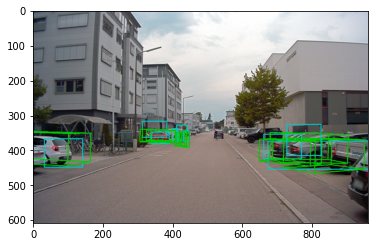

In [16]:
i=0
imobj= test_ds[i]
image= imobj["image"]
image1= np.swapaxes(image, 0,2)
image2=  np.swapaxes(image1, 1,0)
image3= np.array(image2, dtype= 'uint8')
image3b= np.array(image2, dtype= 'uint8')
plt.imshow(image3)
file= r"./predictions/three_task/Mono_3d_Object_Detection/result_new/{}.txt".format(i)
f = open(file, "r")
for line in f:
    print(line)
    x1= float(line.split(',')[3])
    y1= float(line.split(',')[4])
    x2= float(line.split(',')[5])
    y2= float(line.split(',')[6])
    box= [x1,y1,x2,y2]
    for j in range(len(box)):
        box[j]*=0.5
    draw_2d_box(image3, box, color=(0, 200, 200), thickness=2)
    P = np.array([[ 1.00145047e+03, -1.66583918e+03,  3.52945654e+01, -1.74681545e+03],
                     [ 6.76424384e+02, -2.78547356e+01, -1.78625897e+03,  5.27308035e+02],
                        [ 9.99759581e-01,  2.13721864e-02, -4.90013971e-03, -1.70601282e+00],
                         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

    #print(line)
    w3d= float(line.split(',')[7]) 
    h3d= float(line.split(',')[8]) 
    l3d= float(line.split(',')[9]) 
    x3d= float(line.split(',')[10])  
    y3d= float(line.split(',')[11]) 
    z3d= float(line.split(',')[12])
    ry3d= float(line.split(',')[13])

    verts= project_3d(P, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False)
    draw_3d_box(image3, verts, color=(0, 200, 0), thickness=2)
    #path=r"./pred/image_{}.png".format(i)
    #plt.imsave(path, image3)
plt.imshow(image3)

0,Car,0.999341,1346.055298,748.275879,1950.524780,908.007935,1.486570,1.993082,3.898973,17.528779,-6.231415,-0.171771, 2.112064,0.531469

0,Car,0.996398,65.100021,734.137329,284.630615,896.756592,1.438733,1.814122,3.788586,16.614123,8.202839,-0.153915, 1.376009,-0.204052

0,Car,0.996159,679.844421,697.543335,781.251282,763.874390,1.507548,2.044129,3.998396,47.069285,7.177590,-0.227881, 1.420147,-0.155490

0,Pedestrian,0.992950,822.570312,657.004211,883.534058,745.237122,1.821257,0.749983,0.735615,42.252813,3.415841,-0.494302, 2.023425,0.440931

0,Car,0.988258,1323.344849,708.483276,1539.369263,849.740601,1.457529,1.956446,3.651572,22.282605,-5.733567,-0.403558, 0.863445,-0.725460

0,Pedestrian,0.976617,862.844238,689.580566,895.105835,750.434082,1.862251,0.733435,0.720802,40.199307,2.865948,-0.461460, 2.085202,0.502927

0,Pedestrian,0.969298,798.693420,676.778259,830.296326,750.318665,1.785442,0.783769,0.654963,44.075264,4.204075,-0.640882, 2.821395,1.236059

0,Car,0.902468,1455.936890

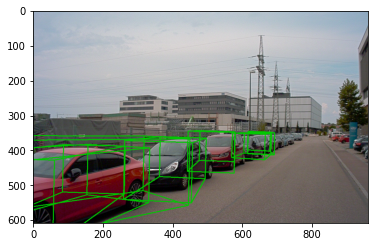

In [17]:
for i in range(len(test_ds)):  
    imobj= test_ds[i]
    image= imobj.image
    image1= np.swapaxes(image, 0,2)
    image2=  np.swapaxes(image1, 1,0)
    image3= np.array(image2, dtype= 'uint8')
    image3b= np.array(image2, dtype= 'uint8')
    plt.imshow(image3)
    file= r"./predictions/three_task/Mono_3d_Object_Detection/result_new/{}.txt".format(i)
    f = open(file, "r")
    for line in f:
        print(line)
        x1= float(line.split(',')[3])
        y1= float(line.split(',')[4])
        x2= float(line.split(',')[5])
        y2= float(line.split(',')[6])
        box= [x1,y1,x2,y2]
        for j in range(len(box)):
            box[j]*=0.5
        #draw_2d_box(image3, box, color=(0, 200, 200), thickness=2)
        P = np.array([[ 1.00145047e+03, -1.66583918e+03,  3.52945654e+01, -1.74681545e+03],
                     [ 6.76424384e+02, -2.78547356e+01, -1.78625897e+03,  5.27308035e+02],
                        [ 9.99759581e-01,  2.13721864e-02, -4.90013971e-03, -1.70601282e+00],
                         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

        #print(line)
        w3d= float(line.split(',')[7]) 
        h3d= float(line.split(',')[8]) 
        l3d= float(line.split(',')[9]) 
        x3d= float(line.split(',')[10])  
        y3d= float(line.split(',')[11]) 
        z3d= float(line.split(',')[12])
        ry3d= float(line.split(',')[13])

        verts= project_3d(P, x3d, y3d, z3d, w3d, h3d, l3d, ry3d, return_3d=False)
        draw_3d_box(image3, verts, color=(0, 200, 0), thickness=2)
    path=r"./predictions/three_task/Mono_3d_Object_Detection/pred/image_{}.png".format(i)
    plt.imsave(path, image3)
    #plt.imshow(image3)